# Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

## Import libraries and packages

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# Add TF GPU for Jetson TX2
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.Session(config=config)

#%matplotlib inline

# tf.__version__, tf.test.is_gpu_available(), tf.test.is_built_with_cuda(), tf.test.gpu_device_name()

## Import data set

In [2]:
data_dir = 'data/clouds_category'
# print(os.listdir(os.path.join(data_dir, 'cirrocumulus', '*.jpg')))

In [3]:
image_dir = os.path.join(data_dir, 'nimbostratus', '*.jpg')
print(image_dir)

data/clouds_category/nimbostratus/*.jpg


In [4]:
def _img_string_to_tensor(image_string, image_size=(40, 40)):
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Convert from full range of uint8 to range [0,1] of float32.
    image_decoded_as_float = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
    # Resize to expected
    image_resized = tf.image.resize_images(image_decoded_as_float, size=image_size)
    
    return image_resized

def make_input_fn(file_pattern, image_size=(40, 40), shuffle=False, batch_size=64, num_epochs=None, buffer_size=4096):
    
    def _path_to_img(path):
        # Get the parent folder of this file to get it's class name
        label = tf.string_split([path], delimiter='/').values[-2]
        print(path)
        # Read in the image from disk
        image_string = tf.read_file(path)
        image_resized = _img_string_to_tensor(image_string, image_size)
        
        return image_resized, label
    
    def _input_fn():
        
        dataset = tf.data.Dataset.list_files(file_pattern)

        if shuffle:
            dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size, num_epochs))
        else:
            dataset = dataset.repeat(num_epochs)

        dataset = dataset.map(_path_to_img, num_parallel_calls=os.cpu_count())
        dataset = dataset.batch(batch_size).prefetch(buffer_size)

        return dataset
    
    dataset = _input_fn()

    return dataset

## Define Parameters

### Define training parameters

In [5]:
num_steps = 17000
batch_size = 8
ckpt_path = "trained_model/saved_model.ckpt"

### Create dataset

In [6]:
dataset = make_input_fn(image_dir, image_size=(64,64), batch_size=batch_size, shuffle=True)
print(dataset)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

Tensor("arg0:0", shape=(), dtype=string)
<PrefetchDataset shapes: ((?, 64, 64, 3), (?,)), types: (tf.float32, tf.string)>


### Define DCGAN network parameters

In [7]:
# dim_image = 2352 # 28 * 28 * 3
# gen_hidden_dim = 256
# dis_hidden_dim = 256
n_noise = 100

In [8]:
# keep_prob= tf.placeholder(dtype=tf.float32, name='keep_prob')
# is_training= tf.placeholder(dtype=tf.bool, name='is_training')

## Define DCGAN functions

### Define Generator

In [9]:

def gen(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):

        """Layer 1"""
        x = tf.layers.dense(x, units=64*64*8)
        x = tf.reshape(x, shape=[-1, 64, 64, 8])
        x = tf.layers.batch_normalization(x, training=True, momentum=0.9)
        x = tf.maximum(x, 0.2)
        print(x.shape)
        
#         """Layer 2"""
#         x = tf.layers.conv2d(x, 128, kernel_size=(5,5), strides=1, padding='SAME')
#         x = tf.layers.batch_normalization(x, training=True, momentum=0.9)
#         x = tf.nn.leaky_relu(x, alpha=0.2)
#         print(x.shape)
        
        """Layer 3"""
        x = tf.layers.conv2d_transpose(x, 512, kernel_size=5, strides=2, padding='SAME')
        x = tf.nn.leaky_relu(x, alpha=0.2)
        print(x.shape)
        
        """Layer 4"""
        x = tf.layers.conv2d(x, 256, kernel_size=5, strides=2, padding='SAME')
        x = tf.layers.batch_normalization(x, training=True, momentum=0.9)
        x = tf.nn.leaky_relu(x, alpha=0.2)
        print(x.shape)
        
#         """Layer 4"""
#         x = tf.layers.conv2d(x, 128, kernel_size=(5,5), strides=1, padding='SAME')
#         x = tf.layers.batch_normalization(x, training=True, momentum=0.9)
#         x = tf.nn.leaky_relu(x, alpha=0.2)
#         print(x.shape)
        
        """Layer 5"""
        x = tf.layers.conv2d(x, 3, kernel_size=5, strides=1, padding='SAME')
        x = tf.nn.tanh(x)
        print(x.shape)
        return x

        

### Define discriminator

In [10]:

def dis(x, reuse=False):
    

    with tf.variable_scope('Discriminator', reuse=reuse):
        
#         '''Layer 1'''
#         x = tf.layers.dense(x, units=16*16*128)
#         x = tf.nn.leaky_relu(x, alpha=0.1)
#         x = tf.layers.batch_normalization(x, training=True, momentum=0.9)
#         x = tf.reshape(x, shape=[-1, 16, 16, 128])
#         print(x.shape)
        
#         '''Layer 2'''
#         x = tf.layers.conv2d(x, 128, kernel_size=(5,5), strides=1, padding='SAME')
#         x = tf.layers.batch_normalization(x, training=True, momentum=0.9)
#         x = tf.nn.leaky_relu(x, alpha=0.1)
#         print(x.shape)
        
#         '''Layer 3'''
#         x = tf.layers.conv2d_transpose(x, 128, kernel_size(2,2), strides=1, padding='SAME')
#         x = tf.layers.batch_normalization(x, training=True, momentum=0.9)
#         x = tf.nn.leaky_relu(x, alpha=0.1)
#         print(x.shape)
        
#         '''Layer 4'''
#         x = tf.layers.conv2d_transpose(x, 128, kernel_size(2,2), strides=1, padding='SAME')
#         x = tf.layers.batch_normalization(x, training=True, momentum=0.9)
#         x = tf.nn.leaky_relu(x, alpha=0.1)
#         print(x.shape)
        
#         '''Layer 5'''
#         x = tf.layers.conv2d(x, 3, kernel_size(5,5), strides=1, padding='SAME')
#         print(x.shape)
#         x = tf.nn.tanh(x)
        

        """Layer 1"""
        x = tf.layers.conv2d(x, kernel_size=4, filters=64, strides=2, 
                             padding='same')
        x = tf.nn.leaky_relu(x, alpha=0.2)      
        """Layer 2"""
        x = tf.layers.conv2d(x, kernel_size=4, filters=128, strides=2, 
                             padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        """Layer 3"""
        x = tf.layers.conv2d(x, kernel_size=4, filters=256, strides=2, 
                             padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.leaky_relu(x, alpha=0.2)

        """Layer 4"""
        x = tf.layers.conv2d(x, kernel_size=4, filters=512, strides=2, 
                             padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.nn.leaky_relu(x, alpha=0.2)
        
        
        """Layer 5"""
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024)
        x = tf.nn.tanh(x)
        x = tf.layers.dense(x, 2)
        
    return x


## Assemble GAN

### Create placeholders for inputs to GAN

In [11]:
# input_noise = tf.placeholder(tf.float32, shape=[None, n_noise])
real_input_image = tf.placeholder(tf.float32, shape=[None, 64, 64, 3])
input_noise = tf.placeholder(tf.float32, shape=[None, n_noise])


### Create generator network

In [12]:
generator = gen(input_noise, reuse=False)

(?, 64, 64, 8)
(?, 128, 128, 512)
(?, 64, 64, 256)
(?, 64, 64, 3)


### Create discriminator networks for fake and real images

In [13]:
# real_dis = dis(real_input_image) # Discriminator for real images
# fake_dis = dis(generator, reuse=True) # Discriminator for generated samples

real_dis = dis(real_input_image) # Discriminator for real images
fake_dis = dis(generator, reuse=True) # Discriminator for generated samples

# Concatenate both together
dis_concat = tf.concat([real_dis, fake_dis], axis=0)

In [14]:
# Stack generator on discriminator
stacked_gan = dis(generator, reuse=True)

### Build targets

In [15]:
dis_target = tf.placeholder(tf.int32, shape=[None])
gen_target = tf.placeholder(tf.int32, shape=[None])

### Define and build loss function

In [17]:
dis_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=dis_concat, labels=dis_target))
gen_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=stacked_gan, labels=gen_target))

# dis_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_concat, labels=dis_target))
# gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=stacked_gan, labels=gen_target))


### Define separate training variables for each optimizer

In [18]:
# Generator network variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
dis_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Define optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)
optimizer_dis = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)

# Create training variables
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_dis = optimizer_gen.minimize(dis_loss, var_list=dis_vars)

# initialize variables
init = tf.global_variables_initializer()

## Create dataset

## Start training

Step 1: Generator Loss: 0.000000, Discriminator Loss: 8.832312
Step 100: Generator Loss: 3.835724, Discriminator Loss: 0.051472
Step 200: Generator Loss: 2.270952, Discriminator Loss: 0.126237
Step 300: Generator Loss: 2.349780, Discriminator Loss: 0.096389
Step 400: Generator Loss: 4.236362, Discriminator Loss: 0.024890
Step 500: Generator Loss: 3.111430, Discriminator Loss: 0.276205
Step 600: Generator Loss: 8.875038, Discriminator Loss: 0.001163
Step 700: Generator Loss: 5.340218, Discriminator Loss: 0.004631
Step 800: Generator Loss: 7.876741, Discriminator Loss: 0.000589
Step 900: Generator Loss: 3.844697, Discriminator Loss: 0.077064
Step 1000: Generator Loss: 5.611947, Discriminator Loss: 0.005362


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


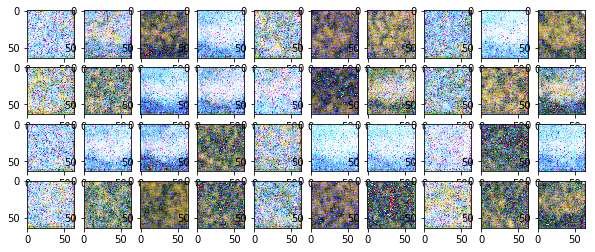

Step 1100: Generator Loss: 3.508866, Discriminator Loss: 0.115602
Step 1200: Generator Loss: 4.430611, Discriminator Loss: 0.007375
Step 1300: Generator Loss: 4.424730, Discriminator Loss: 0.007964
Step 1400: Generator Loss: 4.219346, Discriminator Loss: 0.008005
Step 1500: Generator Loss: 4.710708, Discriminator Loss: 0.009253
Step 1600: Generator Loss: 7.577409, Discriminator Loss: 0.002956
Step 1700: Generator Loss: 5.714577, Discriminator Loss: 0.002395
Step 1800: Generator Loss: 4.903444, Discriminator Loss: 0.009588
Step 1900: Generator Loss: 6.781878, Discriminator Loss: 0.005711
Step 2000: Generator Loss: 7.582078, Discriminator Loss: 0.000976


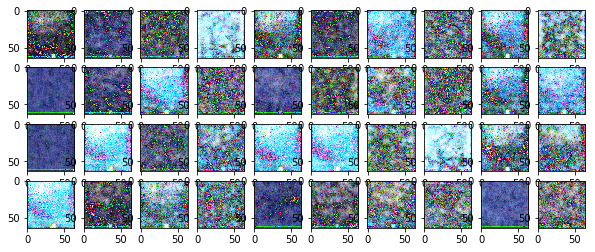

Step 2100: Generator Loss: 3.938142, Discriminator Loss: 0.017337
Step 2200: Generator Loss: 5.529428, Discriminator Loss: 0.004496
Step 2300: Generator Loss: 4.530453, Discriminator Loss: 0.006904
Step 2400: Generator Loss: 4.797313, Discriminator Loss: 0.005991
Step 2500: Generator Loss: 1.010455, Discriminator Loss: 0.323698
Step 2600: Generator Loss: 4.975602, Discriminator Loss: 0.013150
Step 2700: Generator Loss: 2.771923, Discriminator Loss: 0.198070
Step 2800: Generator Loss: 5.891263, Discriminator Loss: 0.006146
Step 2900: Generator Loss: 9.745459, Discriminator Loss: 0.123642
Step 3000: Generator Loss: 4.281116, Discriminator Loss: 0.019877


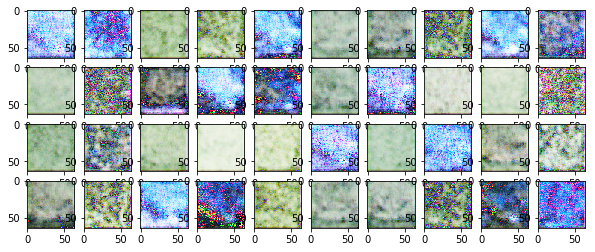

Step 3100: Generator Loss: 6.045903, Discriminator Loss: 0.031776
Step 3200: Generator Loss: 7.057356, Discriminator Loss: 0.143753
Step 3300: Generator Loss: 4.884087, Discriminator Loss: 0.009610
Step 3400: Generator Loss: 8.394062, Discriminator Loss: 0.004563
Step 3500: Generator Loss: 4.453655, Discriminator Loss: 0.026245
Step 3600: Generator Loss: 5.990685, Discriminator Loss: 0.006817
Step 3700: Generator Loss: 4.418509, Discriminator Loss: 0.017279
Step 3800: Generator Loss: 5.779516, Discriminator Loss: 0.059610
Step 3900: Generator Loss: 6.651066, Discriminator Loss: 0.295290
Step 4000: Generator Loss: 6.366549, Discriminator Loss: 0.099421


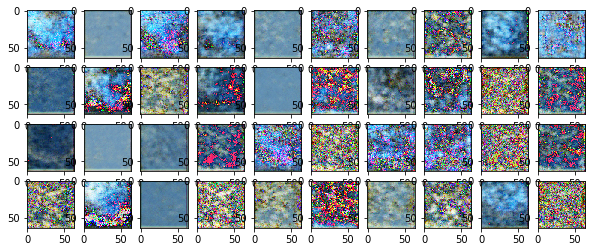

Step 4100: Generator Loss: 6.421558, Discriminator Loss: 0.009693
Step 4200: Generator Loss: 7.242236, Discriminator Loss: 0.005479
Step 4300: Generator Loss: 7.658218, Discriminator Loss: 0.228414
Step 4400: Generator Loss: 5.078978, Discriminator Loss: 0.009831
Step 4500: Generator Loss: 7.737990, Discriminator Loss: 0.002665
Step 4600: Generator Loss: 7.432983, Discriminator Loss: 0.127094
Step 4700: Generator Loss: 5.902303, Discriminator Loss: 0.006639
Step 4800: Generator Loss: 5.413123, Discriminator Loss: 0.009551
Step 4900: Generator Loss: 7.025824, Discriminator Loss: 0.063137
Step 5000: Generator Loss: 8.166328, Discriminator Loss: 0.003006


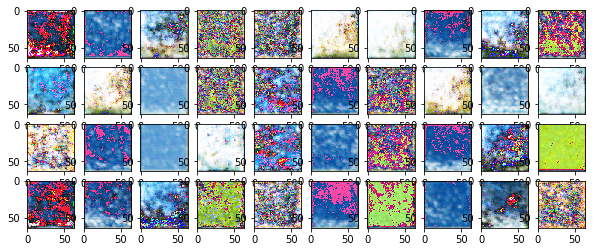

Step 5100: Generator Loss: 6.223444, Discriminator Loss: 0.002662
Step 5200: Generator Loss: 5.923905, Discriminator Loss: 0.023767
Step 5300: Generator Loss: 4.664719, Discriminator Loss: 0.012598
Step 5400: Generator Loss: 5.515078, Discriminator Loss: 0.010309
Step 5500: Generator Loss: 5.007495, Discriminator Loss: 0.135518
Step 5600: Generator Loss: 7.319459, Discriminator Loss: 0.004852
Step 5700: Generator Loss: 8.069626, Discriminator Loss: 0.041222
Step 5800: Generator Loss: 6.264017, Discriminator Loss: 0.026768
Step 5900: Generator Loss: 8.876972, Discriminator Loss: 0.001295
Step 6000: Generator Loss: 6.281148, Discriminator Loss: 0.016080


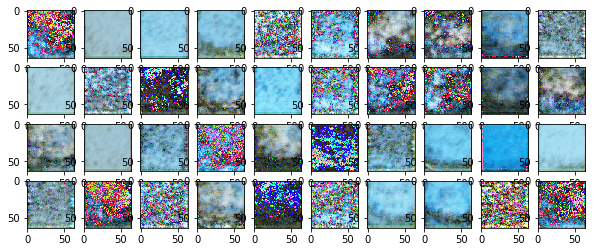

Step 6100: Generator Loss: 5.777146, Discriminator Loss: 0.002898
Step 6200: Generator Loss: 10.035421, Discriminator Loss: 0.005703
Step 6300: Generator Loss: 6.014887, Discriminator Loss: 0.046291
Step 6400: Generator Loss: 5.123506, Discriminator Loss: 0.043903
Step 6500: Generator Loss: 7.658593, Discriminator Loss: 0.005499
Step 6600: Generator Loss: 6.815886, Discriminator Loss: 0.005502
Step 6700: Generator Loss: 8.051989, Discriminator Loss: 0.002989
Step 6800: Generator Loss: 7.221095, Discriminator Loss: 0.001118
Step 6900: Generator Loss: 6.088494, Discriminator Loss: 0.011676
Step 7000: Generator Loss: 6.820736, Discriminator Loss: 0.002035


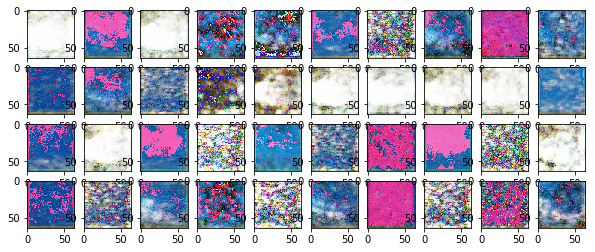

Step 7100: Generator Loss: 7.743722, Discriminator Loss: 0.151293
Step 7200: Generator Loss: 5.874845, Discriminator Loss: 0.009185
Step 7300: Generator Loss: 3.426914, Discriminator Loss: 0.029143
Step 7400: Generator Loss: 7.759719, Discriminator Loss: 0.018707
Step 7500: Generator Loss: 5.491693, Discriminator Loss: 0.009057
Step 7600: Generator Loss: 6.280639, Discriminator Loss: 0.007689
Step 7700: Generator Loss: 5.860939, Discriminator Loss: 0.009818
Step 7800: Generator Loss: 3.796465, Discriminator Loss: 0.015953
Step 7900: Generator Loss: 5.843493, Discriminator Loss: 0.003181
Step 8000: Generator Loss: 4.999132, Discriminator Loss: 0.010745


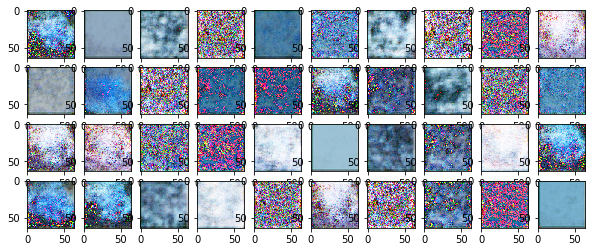

Step 8100: Generator Loss: 5.647507, Discriminator Loss: 0.007724
Step 8200: Generator Loss: 4.882112, Discriminator Loss: 0.030617
Step 8300: Generator Loss: 6.281921, Discriminator Loss: 0.002456
Step 8400: Generator Loss: 7.806873, Discriminator Loss: 0.013615
Step 8500: Generator Loss: 8.235295, Discriminator Loss: 0.030067
Step 8600: Generator Loss: 9.549700, Discriminator Loss: 0.005566
Step 8700: Generator Loss: 6.114892, Discriminator Loss: 0.002636
Step 8800: Generator Loss: 6.112772, Discriminator Loss: 0.004269
Step 8900: Generator Loss: 8.004331, Discriminator Loss: 0.002001
Step 9000: Generator Loss: 5.296723, Discriminator Loss: 0.017592


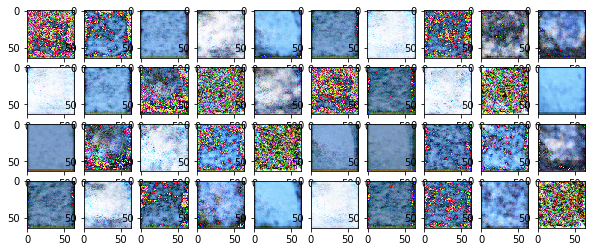

Step 9100: Generator Loss: 5.129060, Discriminator Loss: 0.041296
Step 9200: Generator Loss: 4.962566, Discriminator Loss: 0.018482
Step 9300: Generator Loss: 6.892953, Discriminator Loss: 0.003960
Step 9400: Generator Loss: 6.956235, Discriminator Loss: 0.001751
Step 9500: Generator Loss: 5.833589, Discriminator Loss: 0.004009
Step 9600: Generator Loss: 6.777245, Discriminator Loss: 0.002282
Step 9700: Generator Loss: 7.313959, Discriminator Loss: 0.011291
Step 9800: Generator Loss: 8.223568, Discriminator Loss: 0.006849
Step 9900: Generator Loss: 6.338776, Discriminator Loss: 0.014209
Step 10000: Generator Loss: 7.710765, Discriminator Loss: 0.000808


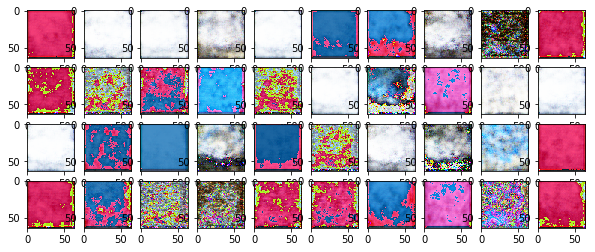

Step 10100: Generator Loss: 7.237337, Discriminator Loss: 0.006070
Step 10200: Generator Loss: 5.099095, Discriminator Loss: 0.008700
Step 10300: Generator Loss: 4.881556, Discriminator Loss: 0.013263
Step 10400: Generator Loss: 7.218904, Discriminator Loss: 0.005852
Step 10500: Generator Loss: 7.502444, Discriminator Loss: 0.010282
Step 10600: Generator Loss: 5.314161, Discriminator Loss: 0.015426
Step 10700: Generator Loss: 4.679618, Discriminator Loss: 0.011084
Step 10800: Generator Loss: 4.679734, Discriminator Loss: 0.009511
Step 10900: Generator Loss: 5.280912, Discriminator Loss: 0.060176
Step 11000: Generator Loss: 5.950557, Discriminator Loss: 0.002501


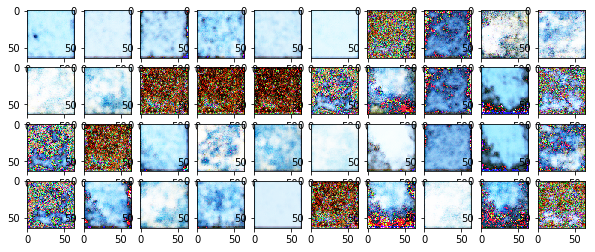

Step 11100: Generator Loss: 7.797688, Discriminator Loss: 0.001628
Step 11200: Generator Loss: 7.480731, Discriminator Loss: 0.003384
Step 11300: Generator Loss: 9.599497, Discriminator Loss: 0.009833
Step 11400: Generator Loss: 13.702973, Discriminator Loss: 0.000208
Step 11500: Generator Loss: 8.444913, Discriminator Loss: 0.004947
Step 11600: Generator Loss: 8.003632, Discriminator Loss: 0.000844
Step 11700: Generator Loss: 10.674955, Discriminator Loss: 0.389934
Step 11800: Generator Loss: 9.782316, Discriminator Loss: 0.002831
Step 11900: Generator Loss: 6.977033, Discriminator Loss: 0.004899
Step 12000: Generator Loss: 8.838621, Discriminator Loss: 0.020267


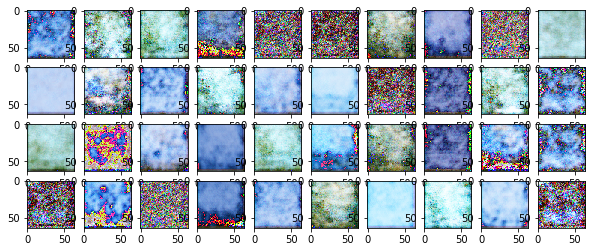

Step 12100: Generator Loss: 4.968731, Discriminator Loss: 0.004724
Step 12200: Generator Loss: 5.815993, Discriminator Loss: 0.002809
Step 12300: Generator Loss: 11.441612, Discriminator Loss: 0.007954
Step 12400: Generator Loss: 6.404527, Discriminator Loss: 0.002075
Step 12500: Generator Loss: 7.698380, Discriminator Loss: 0.002608
Step 12600: Generator Loss: 8.135605, Discriminator Loss: 0.003193
Step 12700: Generator Loss: 6.508024, Discriminator Loss: 0.004365
Step 12800: Generator Loss: 7.587206, Discriminator Loss: 0.000980
Step 12900: Generator Loss: 7.463302, Discriminator Loss: 0.001792
Step 13000: Generator Loss: 7.380654, Discriminator Loss: 0.135799


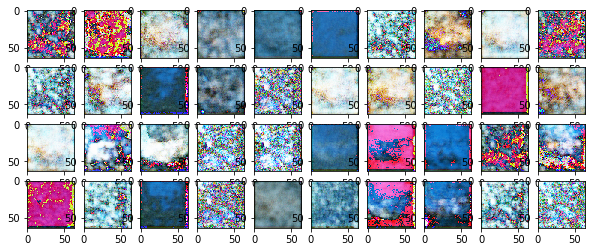

Step 13100: Generator Loss: 6.255938, Discriminator Loss: 0.002674
Step 13200: Generator Loss: 7.302662, Discriminator Loss: 0.049287
Step 13300: Generator Loss: 5.217009, Discriminator Loss: 0.008202
Step 13400: Generator Loss: 6.973866, Discriminator Loss: 0.002290
Step 13500: Generator Loss: 5.803428, Discriminator Loss: 0.001854
Step 13600: Generator Loss: 7.591259, Discriminator Loss: 0.002097
Step 13700: Generator Loss: 3.903852, Discriminator Loss: 0.321602
Step 13800: Generator Loss: 8.690956, Discriminator Loss: 0.006476
Step 13900: Generator Loss: 7.176332, Discriminator Loss: 0.002224
Step 14000: Generator Loss: 5.797088, Discriminator Loss: 0.002762


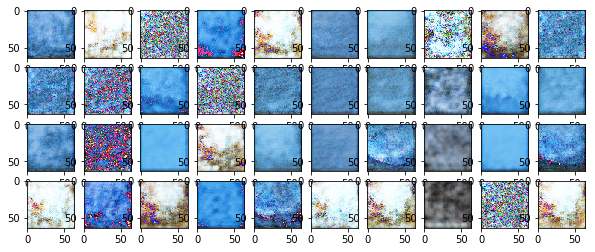

Step 14100: Generator Loss: 6.152602, Discriminator Loss: 0.007780
Step 14200: Generator Loss: 6.068860, Discriminator Loss: 0.005228
Step 14300: Generator Loss: 9.438732, Discriminator Loss: 0.001699
Step 14400: Generator Loss: 5.929070, Discriminator Loss: 0.007728
Step 14500: Generator Loss: 6.527442, Discriminator Loss: 0.009387
Step 14600: Generator Loss: 7.873891, Discriminator Loss: 0.001575
Step 14700: Generator Loss: 6.838457, Discriminator Loss: 0.001203
Step 14800: Generator Loss: 8.542422, Discriminator Loss: 0.000280
Step 14900: Generator Loss: 6.222110, Discriminator Loss: 0.024721
Step 15000: Generator Loss: 6.143371, Discriminator Loss: 0.002458


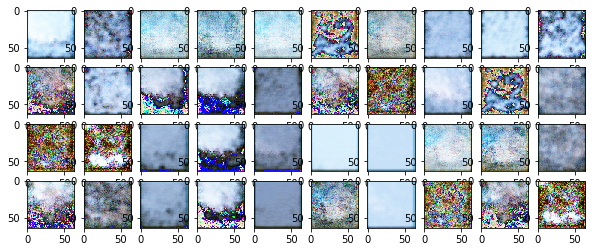

Step 15100: Generator Loss: 7.435469, Discriminator Loss: 0.000787
Step 15200: Generator Loss: 8.158904, Discriminator Loss: 0.000884
Step 15300: Generator Loss: 9.502485, Discriminator Loss: 0.007787
Step 15400: Generator Loss: 6.327224, Discriminator Loss: 0.002092
Step 15500: Generator Loss: 9.426765, Discriminator Loss: 0.006661
Step 15600: Generator Loss: 8.374874, Discriminator Loss: 0.000894
Step 15700: Generator Loss: 8.129828, Discriminator Loss: 0.002267
Step 15800: Generator Loss: 8.159565, Discriminator Loss: 0.000901
Step 15900: Generator Loss: 9.323906, Discriminator Loss: 0.000430
Step 16000: Generator Loss: 5.352535, Discriminator Loss: 0.147110


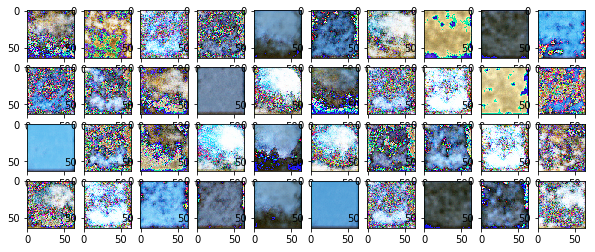

Step 16100: Generator Loss: 4.522475, Discriminator Loss: 0.030292
Step 16200: Generator Loss: 6.803449, Discriminator Loss: 0.003352
Step 16300: Generator Loss: 3.916368, Discriminator Loss: 0.020575
Step 16400: Generator Loss: 5.881380, Discriminator Loss: 0.012238
Step 16500: Generator Loss: 7.437392, Discriminator Loss: 0.000471
Step 16600: Generator Loss: 6.995412, Discriminator Loss: 0.001247
Step 16700: Generator Loss: 9.859550, Discriminator Loss: 0.002148
Step 16800: Generator Loss: 8.533312, Discriminator Loss: 0.003023
Step 16900: Generator Loss: 9.384703, Discriminator Loss: 0.000818
Step 17000: Generator Loss: 7.474482, Discriminator Loss: 0.000510


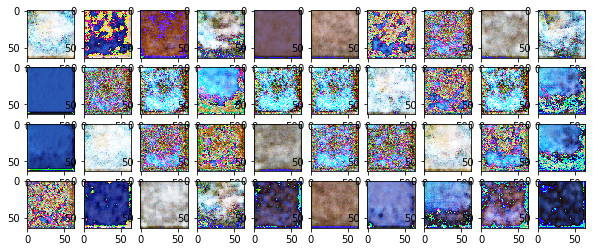

Model saved in path: trained_model/saved_model.ckpt


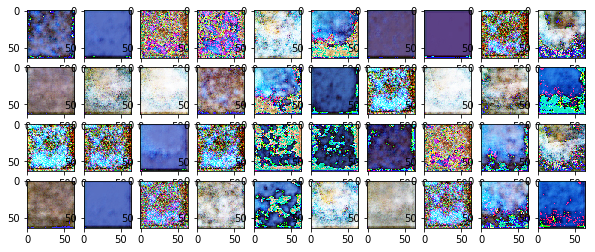

In [19]:
saver = tf.train.Saver()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)
    sess.run(iterator.initializer)
    for i in range(1, num_steps+1):
        # Prepare Input Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = sess.run(next_element)
        batch_x = np.reshape(batch_x, newshape=[-1, 64, 64, 3])
        # Generate noise to feed to the generator
        z = np.random.normal(-1., 1., size=[batch_size, n_noise])

        # Prepare Targets (Real image: 1, Fake image: 0)
        # The first half of data fed to the generator are real images,
        # the other half are fake images (coming from the generator).
        batch_disc_y = np.concatenate(
            [np.ones([batch_size]), np.zeros([batch_size])], axis=0)
        # Generator tries to fool the discriminator, thus targets are 1.
        batch_gen_y = np.ones([batch_size])

        # Training
        feed_dict = {real_input_image: batch_x, input_noise: z,
                     dis_target: batch_disc_y, gen_target: batch_gen_y}
        
#         print("step: %i" %i)

        for xtra in range(0, 1):
            _ = sess.run([train_gen], feed_dict=feed_dict)
        
        _, _, gl, dl = sess.run([train_gen, train_dis, gen_loss, dis_loss],
                                feed_dict=feed_dict)
#         _, _, gl, dl = sess.run([train_gen, train_dis, gen_loss, dis_loss],
#                                 feed_dict=feed_dict)
        if i % 100 == 0 or i == 1:
            print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
            
        if i % 1000 == 0:
            f, a = plt.subplots(4, 10, figsize=(10, 4))
            for b in range(10):
                # Noise input.
                z_test = np.random.uniform(-1., 1., size=[4, n_noise])
                g_test = sess.run(generator, feed_dict={input_noise: z_test})
                for j in range(4):
                    # Generate image from noise. Extend to 3 channels for matplot figure.
                    img = np.reshape(np.repeat(g_test[j][:, :, np.newaxis], 1, axis=2),
                                     newshape=(64, 64, 3))
                    a[j][b].imshow((img*255).astype(np.uint8))
            f.show()
            plt.show()

    # Save the variable to disk
    
    save_path = saver.save(sess, ckpt_path)
    print("Model saved in path: %s" % save_path)
    
    # Generate images from noise, using the generator network.
    f, a = plt.subplots(4, 10, figsize=(10, 4))
    for i in range(10):
        # Noise input.
        z = np.random.uniform(-1., 1., size=[4, n_noise])
        g = sess.run(generator, feed_dict={input_noise: z})
        for j in range(4):
            # Generate image from noise. Extend to 3 channels for matplot figure.
            img = np.reshape(np.repeat(g[j][:, :, np.newaxis], 1, axis=2),
                             newshape=(64, 64, 3))
            a[j][i].imshow((img * 255).astype(np.uint8))

    f.show()
    plt.show()